The following Notebook contains functions for programmatically creating market-specific visualizations for the Pampers consumer data platform. Segment does not currently have APIs available to access this data in our Public API, and thus this code leverages GraphQL and the Segment Gateway API to retrieve connections from Segment. The D3.js JavaScript library is used to generate the diagram, using the data which is generated by this program and saved as a <b>data.js</b> file and a D3.js script in the <b>sankey.js</b> file (which can be edited to modify certain display parameters).
<br><br>
This <b>data.js</b> file consists of a dictionary containing two keys, nodes and links, each of which contains an array of entries.
<br><br>
An entry in the <b>nodes</b> array contains the display "name" of the node, the column "col" where the node belongs in the visualization, and a "type" which is used to associate the node to a display icon.<br><br>

An entry in the <b>links</b> array contain the "source" node connected to the "target" node, a "value" designating the rendered link line thickness, and "optimal" set to "yes" (a required Sankey setting. <br><br>

The functions below also write to a <b>dist/icons2.js</b> file which maps each of the node types to a URL of the rendered icon referenced from the Segment CDN. 


## How to use

A valid Segment Authentication key must be placed in a file named <b>'auth_key.segkey'</b> within the same directory as this program file. This key is used to provide authentication when making calls to the Segment API to obtain source, destination, connections and Personas data. Failure to provide a valid token will lead to an HTTP 401 Error due to invalid authentication when making calls to the API while running this program.
<br>
<br>
A valid country code (Currently supported are 'FR', 'DE', 'US', 'JP', 'CA', 'TW', 'TR', 'NL', 'IL', 'HK', 'GB', 'BE') must be provided within a <b>country_code.csv</b> file located in the same directory as this program file. This country code dictates the Segment Space ID for which we will query the data. The space ID corresponding to the provided country code is drawn from 'country_dict' dictionary variable in the "Setup and Utility Functions to Retrieve GraphQL Queries" section. This dictionary must be updated to represent modifications if any space IDs are changed, and can be expanded with additional space IDs.
<br>
<br>
Once the two above files are provided, this program can be ran. The output will be generated in the form of an HTML file, index.html, in this directory.
<br>
<br>
In order to add any additional sources or destinations (e.g. peripheral microservices), a 'microservices_<b><i>[YOUR COUNTRYCODE]</i></b>.csv' file must be placed within the same directory as this file. Using this feature, additional custom nodes and links can be created within the visualization, without a need to directly modify any code. To use this functionality, the microservices csv file must be formatted using the following format: each line contains 1 entry which corresponds to either a node or a link, and will then supply the node's "name", "col" and "type" or the link's "source" and "target" respectively. Thus the format of each line is one of the 2 below:
<br>
node,<b>nodename</b>,<b>col</b>,<b>type</b>
<br>
link,<b>sourcename</b>,<b>targetname</b>
<br><br>
Samples of such microservice definition files are attached within the directory.
<br><br>
To select the col value of a node, as a rule of them, nodes to be added to the left of the graph will have col 1 or 2. Nodes added to the right will have col 6 or 7. However, it is worth experimenting with different col values to verify how they affect the graph layout until a desirable configuration is achieved.
<br><br>
Note that the names are whitespace and letter-casing sensititive. Any reference to a non-existent node name within a link will cause an error during the diagram creation. Note also that at times, we want separate nodes representing a service (depending for example on whether it's acting as a source or a destination). Since duplicate node names cause issues with link definitions (since link sources and destinations are defined by name, and D3 therefore has no way of differentiating between 2 nodes with duplicate names), please be mindful of the whitespacing which is sometimes used to differentate 2 nodes by name without affecting the display name on the diagram. Furthermore, if you wish to add a node with a name which already exists within the diagram, be mindful to use whitespace at the beginning/end of the name so as to differentiate the names to allow the links to correctly detect which of the 2 nodes they are targeting. In case of confusion, consult the data.js file to consult the specific naming of each node.

## Import Modules

In [1]:
import requests
import json
import datetime

## Setup and Utility Functions to Retrieve GraphQL Queries

Loading the authentication token and country code from the auth_token.segkey and country_code.csv files in the directory, respectively.
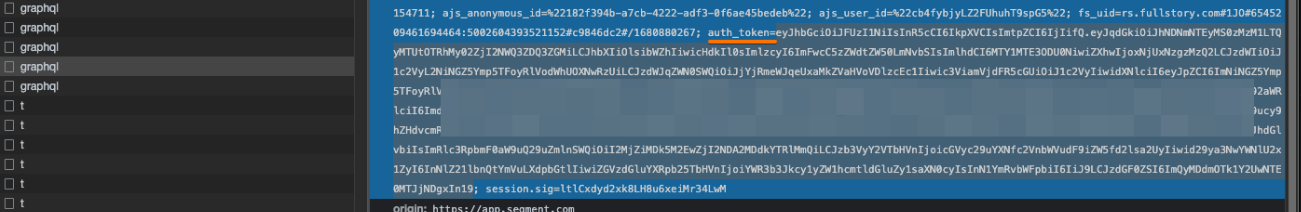

In [2]:
## load Auth Token from File to keep off of GitHub
with open('auth_token.segkey', 'r') as auth_file:
    auth_token = auth_file.read()

##dict of Segment space IDs for each country code
country_dict = {
    'FR': 'spa_1mhhrMQQbt9zY51oi2qFSjQy2iT', #ALL WORKING
    'DE': 'spa_1iHD1LvtO0x7mqjNt8nw7vShGvM', #ALL WORKING
    'US': 'spa_1iHD3ZONReYPmaG2KhLj59N7w6w', #ALL WORKING
    'JP': 'spa_1iGnM1zxbHc0CHMhYDRFPyVu5Fm', #ALL WORKING. Profile Search&Edit source and its links (including CPC and CPC microservice) added manually. Should they be?
    'CA': 'spa_1dzaUlbs2hsgIKmTgpE2eKFUfeM', #ALL WORKING
    'TW': 'spa_1l8yiAdE3YNKKKcEsUaVkx5ZysW', #TESTED, WORKING
    'TR': 'spa_1oLN379NIruTGAy9OvqyXFSqNXG', #TESTED, WORKING
    'NL': 'spa_1oyoYQpIlSNBtmI5RW1BhMgS3vd', #TESTED, WORKING
    'IL': 'spa_1l8yGUl3weaMIt7fgLWK5kQ5H4g', #TESTED, WORKING
    'HK': 'spa_1l8ygt1UNwZqBMNQfbXSRSRG7HD', #TESTED, WORKING
    'GB': 'spa_1k9HonRCrJr8fBJXtjQQJ3UPINF', #TESTED, WORKING
    'BE': 'spa_1oyoRDUt7IVM7DuOnxClApnIIoM' #TESTED, WORKING
}

##extracting country code from country_code.csv file in directory
with open('country_code.csv', 'r+') as f:
    f.seek(0)
    lines = [line for line in f]
global_cc = lines[0].strip()
##checking country code against valid codes
if not global_cc in [
        "AE",
        "AR",
        "AT",
        "BE",
        "BR",
        "CA",
        "CL",
        "CN",
        "CZ",
        "DE",
        "ES",
        "FI",
        "FR",
        "GB",
        "GR",
        "HK",
        "HR",
        "HU",
        "IB",
        "IE",
        "IL",
        "JP",
        "LA",
        "NL",
        "PH",
        "PL",
        "PO",
        "PT",
        "RO",
        "RU",
        "SA",
        "SE",
        "TR",
        "TW",
        "UA",
        "UK",
        "US",
    ]:
    raise Exception('Invalid country code in country_code.csv!')
spaceID = country_dict[global_cc]

The following 2 helper functions (openGraphQLQueryFile, getGraphQLQuery) abstract much of the interaction with GraphQL and the Segment Gateway API and are used by the visualization function. Each query request is stored as a file to encourage modularity. Variables are a dictionary and are specific to the query operation. Finally - all GraphQL calls are HTTPS POST and return the query.

In [3]:
## function to open a saved GraphQL query from file
def openGraphQLQueryFile(filename):
    with open(filename, 'r') as query_file:
        query = query_file.read()
        query = query.replace('\t', '')
    return query

In [4]:
## function to retrieve JSON from GraphQL Query + Variables
def getGraphQLQuery(query, variables):
    headers = {'authorization': 'Bearer ' + auth_token}
    url = "https://app.segment.com/gateway-api/graphql"
    request = requests.post(url, json={'query': query, 'variables': variables}, headers=headers, verify=False)
    if request.status_code == 200:
        return request.json()
    else:
        raise Exception("Error Code: {}".format(request.status_code))

A couple of other self-explanatory helper functions.

In [5]:
## function to retrieve Personas Space Data by Workspace Slug and Space ID
def getPersonasAudiences(workspaceSlug, spaceID):
    variables = {"workspaceSlug": workspaceSlug, "spaceId": spaceID}
    return getGraphQLQuery(openGraphQLQueryFile('getPersonasAudience.gql'), variables)

In [6]:
## function to retrieve a Source by Write Key
def getSourceByWriteKey(workspaceSlug, writekey):
    sources = list()
    variables = {"workspaceSlug": workspaceSlug}
    querydat = getGraphQLQuery(openGraphQLQueryFile('getSources.gql'), variables)
    return [source for source in querydat['data']['workspace']['sources'] if source['writeKeys'][0] == writekey][0]

In [7]:
## function to retrieve a list of Write Keys from a Repeater Destination by ID
def getRepeatKeysByRepeaterID(workspaceSlug, repeaterID):
    repeaters = list()
    variables = {"workspaceSlug": workspaceSlug}
    querydat = getGraphQLQuery(openGraphQLQueryFile('getDestinations.gql'), variables)
    for destination in querydat['data']['workspace']['destinations']:
        if destination != {}:
            if destination['metadata']['slug'] == 'repeater':
                repeaters.append(destination)
    return [repeater['settings']['repeatKeys'] for repeater in repeaters if repeater['id'] == repeaterID][0]

## Functions to Build Diagram

Below are the main functions that creates the files for the visualization.<br>
The code is further commented throughout to understand how the visualization data is being processed.

In [8]:
##function to extract country code from a source name
def extract_cc(sname):
    whitelist_cc = [
        "AE",
        "AR",
        "AT",
        "BE",
        "BR",
        "CA",
        "CL",
        "CN",
        "CZ",
        "DE",
        "ES",
        "FI",
        "FR",
        "GB",
        "GR",
        "HK",
        "HR",
        "HU",
        "IB",
        "IE",
        "IL",
        "JP",
        "LA",
        "NL",
        "PERSONAS",
        "PH",
        "PL",
        "PO",
        "PT",
        "RO",
        "RU",
        "SA",
        "SE",
        "TR",
        "TW",
        "UA",
        "UK",
        "US",
    ]
    if not sname.strip().lower().startswith("personas"):
        _preclean = sname.strip().replace("(", "").replace(")", "")
        cc = _preclean[:2]
        if cc in whitelist_cc:
            return cc
        else:
            return "OTHER"
    else:
        return "PERSONAS"

##get connections nodes and links for a workspace
def getFlowData(workspaceSlug):
    #querying data
    variables = {"workspaceSlug": workspaceSlug}
    querydat = getGraphQLQuery(openGraphQLQueryFile('getConnectionsSources.gql'), variables)
    
    connectionsSources = {'country_code': [], 'source_display_name': [], 'source_name': [], 'source_id': [],
                       'source_write_key': [], 'destination': [], 'enabled': [],
                      'destination_write_key': [], 'repeater_source_name': []}

    ## for each of the Connections Sources
    for source in querydat['data']['workspace']['sources']:
        if extract_cc(source['name']) != global_cc and extract_cc(source['name']) != "OTHER":
            continue
        ## check if the Source has any Connected Destinations
        if source['connectedDestinations'] != []:
            ## for each of the Connections Sources Destinations
            for destination in source['connectedDestinations']:
                ## use Jerome's Function to set Country Code
                connectionsSources['country_code'].append(extract_cc(source['name']))
                
                ## add Source-specific information, adds duplicative Source information per Destination
                connectionsSources['source_write_key'].append(source['writeKeys'][0])
                connectionsSources['source_display_name'].append(source['name'])
                connectionsSources['source_name'].append(source['slug'])
                connectionsSources['source_id'].append(source['id'])
                
                ## add Destination-specific information
                connectionsSources['destination'].append(destination['name'])
                connectionsSources['enabled'].append(destination['enabled'])
                
                # check if the Destination is a Repeater
                if destination['metadata']['slug'] == 'repeater':
                    ## assumes there is ONLY 1 Repeat Key (which seems to be OK with Jerome's data)
                    repeatkey = destination['settings']['repeatKeys'][0]
                    connectionsSources['destination_write_key'].append(repeatkey)
                    ## find the Source Name from the Repeat Key
                    for repeatsource in querydat['data']['workspace']['sources']:
                        if repeatsource['writeKeys'][0] == repeatkey:
                            connectionsSources['repeater_source_name'].append(repeatsource['name'])
                # destination is not a Repeater
                else:
                    connectionsSources['destination_write_key'].append(None)
                    connectionsSources['repeater_source_name'].append(None)
                    
        ## Source doesn't have any Connected Destinations
        else:
                ## use Jerome's Function to set Country Code
                connectionsSources['country_code'].append(extract_cc(source['name']))       
                    
                ## add Source-specific information
                connectionsSources['source_write_key'].append(source['writeKeys'][0])        
                connectionsSources['source_display_name'].append(source['name'])
                connectionsSources['source_name'].append(source['slug'])
                connectionsSources['source_id'].append(source['id'])
                
                ## add empty Destination values since doesn't exist
                connectionsSources['destination'].append(None)
                connectionsSources['enabled'].append(None)
                connectionsSources['destination_write_key'].append(None)
                connectionsSources['repeater_source_name'].append(None)

    return connectionsSources
                
def buildConnectionsSankeyDataIcons(workspace):
    ## initialize our data dict for nodes/links & icons
    data = {'nodes': [], 'links': []}
    urlCode = {}
    flow_data = getFlowData(workspace)

    ## retrieve Sources with Destinations
    sources = getGraphQLQuery(openGraphQLQueryFile('getSources.gql'), {'workspaceSlug': workspace})    

    ##create blacklist of country_codes:
    blacklist = [
        "AE",
        "AR",
        "AT",
        "BE",
        "BR",
        "CA",
        "CL",
        "CN",
        "CZ",
        "DE",
        "ES",
        "FI",
        "FR",
        "GB",
        "GR",
        "HK",
        "HR",
        "HU",
        "IB",
        "IE",
        "IL",
        "JP",
        "LA",
        "NL",
        "PH",
        "PL",
        "PO",
        "PT",
        "RO",
        "RU",
        "SA",
        "SE",
        "TR",
        "TW",
        "UA",
        "UK",
        "US",
    ]

    ##remove US from blacklist, can later update to remove some other countries
    blacklist.remove(global_cc)

    ##bool([ele for ele in blacklist if(ele in source['name'].lower())])
    ######################################################################################
    ## add each Source and Connected Destinations
    for source in sources['data']['workspace']['sources']:
        ## don't add Personas Sources
        ##if "personas" not in source['name'].lower() and not bool([ele for ele in blacklist if(ele in source['name'].upper())]):

        is_right_country = True
        for cc in blacklist:
            if (cc+" ") in source['name'] or ("("+cc+")") in source['name']:
                is_right_country = False
        if "personas" not in source['name'].lower() and is_right_country and not source['metadata']['slug'] == 'repeater':
            ## add entry for each Source to data dict
            node_entry = {'name': source['name'], 'col': 1, 'type': source['metadata']['slug']}
            data['nodes'].append(node_entry)

            ## add entry for metaslug and icon URL to urlCode dict
            if source['metadata']['logos']['mark']:
                urlCode[source['metadata']['slug']] = source['metadata']['logos']['mark']
            else:
                urlCode[source['metadata']['slug']] = source['metadata']['logos']['default']

            ## add entry for each Connected Destination to data dict
            if source['connectedDestinations'] != []:
                for destination in source['connectedDestinations']:
                    ## only add ENABLED Destinations
                    if destination['enabled'] == True:
                        node_entry = {'name': destination['name'], 'col': 2, 'type': destination['metadata']['slug']}
                        links_entry = {'source': source['name'], 'target': destination['name'], 'value': 1, 'optimal': 'yes'}
                        data['links'].append(links_entry)
                        ## add entry for metaslug and icon URL to urlCode dict
                        if destination['metadata']['logos']['mark']:
                            urlCode[destination['metadata']['slug']] = destination['metadata']['logos']['mark']
                        else:
                            urlCode[destination['metadata']['slug']] = destination['metadata']['logos']['default']
                        ## only add a Destination if it doesn't already exist
                        if node_entry not in data['nodes']:   
                            data['nodes'].append(node_entry)
                    
    ######################################################################################
    ##find all repeaters and deal with them        
    
    for i in range(len(flow_data['country_code'])):
        if not flow_data['repeater_source_name'][i] == None:
            for node in data['nodes']:
                if node['name'] == flow_data['repeater_source_name'][i]:
                    node['col'] = 3
                    links_entry = {'source': 'Repeater', 'target': node['name'], 'value': 1, 'optimal': 'yes'}
                    data['links'].append(links_entry)
                    for link in data['links']:
                        if link['source'] == node['name']:
                            for node2 in data['nodes']:
                                if node2['name'] == link['target']:
                                    node2['col'] = 4

    ##merge similar sources
    ##merge similar destinations

    replacements = [['Amplit', 'Amplitude', False],['Git', 'Git Download Trigger', False], ['GCS Filtered', 'GCS Filtered data', False]]
    for pair in replacements:
        count = 0
        for node in data['nodes']:
            if pair[0] in node['name']:
                count += 1
        newname = pair[1] + " (" + str(count) + ")"
        for node in data['nodes']:
            if pair[0] in node['name']:
                if not pair[2]:
                    pair[2] = True
                    node['name'] = newname
                else:
                    data['nodes'].remove(node)
        for link in data['links']:
            if pair[0] in link['source']:
                link['source'] = newname
            if pair[0] in link['target']:
                link['target'] = newname


    ##merge braze instances:

    tobemerged = ['Braze for ' + global_cc + ' T2 android', 'Braze for ' + global_cc + ' T2 App Server ', 'Braze for ' + global_cc + ' T2 ios', 'Braze']
    new_name_created = False
    to_be_merged_count = 0
    for node in data['nodes']:
        if node['name'] in tobemerged:
            to_be_merged_count+=1
    for i in range(len(tobemerged)):
        newname = 'Braze (' + str(to_be_merged_count) + ')'
        for link in data['links']:
            if link['source'] == tobemerged[i]:
                link['source'] = newname
            if link['target'] == tobemerged[i]:
                link['target'] = newname
        for node in data['nodes']:
            if node['name'] == tobemerged[i]:
                if not new_name_created:
                    node['name'] = newname
                    new_name_created = True
                else:
                    node['name'] = 'tobedeleted'

    for node in data['nodes']:
        if node['name'] == 'tobedeleted':
            data['nodes'].remove(node)


    ##return connections data and urlCodes for icons
    return [data, urlCode]

##Get and process Personas data, build diagram
def buildDiagram(workspace, spaceID):

    ##Obtaining and processing Personas data

    ## retrieve Personas Audiences and Computed Traits by Workspace Slug + Space ID
    jsonsample = getPersonasAudiences(workspace, spaceID)
    ## get Personas Space name and Set Logo from Web since not in API
    personas_space = jsonsample['data']['workspace']['space']['name']
    personas_logo = 'https://res.cloudinary.com/segment-cx/image/upload/v1588865735/Data%20Flow/personas_purple.svg'
    audiences_logo = 'https://res.cloudinary.com/segment-cx/image/upload/v1645826780/Data%20Flow/audience.png'
    computed_trait_logo = 'https://res.cloudinary.com/segment-cx/image/upload/v1645826795/Data%20Flow/trait.png'
    
    ## initialize our data dict for nodes/links & icons
    data = {'nodes': [], 'links': []}
    urlCode = {}
    
    ## initialize our column labels
    columnsText = ["Personas Sources","Personas", "Audiences/Computed Traits", "Destinations"]
    
    ## initialize flags for detecting additional recursion required for Repeaters
    hasRepeaterDestination = False
    hasRepeaterRepeaterDestination = False

    ## add a fixed Personas Space node & icon; fixed Audiences icon; fixed Computed Traits icon
    data['nodes'].append({'name': personas_space, 'col': 2, 'type': 'personas'})
    urlCode['personas'] = personas_logo
    urlCode['audience'] = audiences_logo
    urlCode['computedtrait'] = computed_trait_logo

    ######################################################################################
    ## add each Source and link to Personas Space
    for source in jsonsample['data']['workspace']['space']['sources']:
        
        ## remove Personas Sources(!) by checking metadata slug
        if source['metadata']['slug'] != 'personas-compute':
            ## add entry and link for each Source to data dict
            node_entry = {'name': source['name'], 'col': 1, 'type': source['metadata']['slug']}
            data['nodes'].append(node_entry)

            links_entry = {'source': source['name'], 'target': personas_space, 'value': 1, 'optimal': 'yes'}
            data['links'].append(links_entry)
            
            ## add entry for metaslug and icon URL to urlCode dict
            if source['metadata']['logos']['mark']:
                urlCode[source['metadata']['slug']] = source['metadata']['logos']['mark']
            else:
                urlCode[source['metadata']['slug']] = source['metadata']['logos']['default']
       
    ######################################################################################
    ## add each Audience node and link from Personas Space, only for ENABLED AUDIENCES
    ## for every Audience
    for audience in jsonsample['data']['workspace']['space']['audiences']['data']:
        ## check if Audience is ENABLED
        if audience['enabled'] == True:
            ## add entry and link for each Audience
            node_entry = {'name': audience['name'], 'col': 3, 'type': 'audience'}
            data['nodes'].append(node_entry)

            links_entry = {'source': personas_space, 'target': audience['name'], 'value': 1, 'optimal': 'yes'}
            data['links'].append(links_entry)

            ## add entry and link for each Audience Destination
            if audience['destinations'] != []:
                ## for each Destination (now supports many Destinations)
                for destination in audience['destinations']:
                    ## only add ENABLED Destinations
                    if destination['enabled'] == True:
                        node_entry = {'name': destination['name'], 'col': 4, 'type': destination['metadata']['slug']}
                        links_entry = {'source': audience['name'], 'target': destination['name'], 'value': 1, 'optimal': 'yes'}
                        data['links'].append(links_entry)
                        ## add entry for metaslug and icon URL to urlCode dict
                        if destination['metadata']['logos']['mark']:
                            urlCode[destination['metadata']['slug']] = destination['metadata']['logos']['mark']
                        else:
                            urlCode[destination['metadata']['slug']] = destination['metadata']['logos']['default']
                        ## only add a Destination if it doesn't already exist
                        if node_entry not in data['nodes']:   
                            data['nodes'].append(node_entry)
                        ## set flag if the Destination is a Repeater
                        if destination['metadata']['slug'] == 'repeater':
                            hasRepeaterDestination = True

    ######################################################################################
    ## add each Computed Trait node and link from Personas Space, only for ENABLED COMPUTED TRAITS
    ## for every Computed Trait
    for ctrait in jsonsample['data']['workspace']['space']['computedTraits']['data']:
        ## check if Computed Trait is ENABLED
        if ctrait['enabled'] == True:
            ## add entry and link for each Computed Trait
            node_entry = {'name': ctrait['name'], 'col': 3, 'type': 'computedtrait'}
            data['nodes'].append(node_entry)

            links_entry = {'source': personas_space, 'target': ctrait['name'], 'value': 1, 'optimal': 'yes'}
            data['links'].append(links_entry)

            ## add entry and link for each Computed Trait Destination
            if ctrait['destinations'] != []:
                ## for each Destination (now supports many Destinations)
                for destination in ctrait['destinations']:
                    ## only add ENABLED Destinations
                    if destination['enabled'] == True:
                        node_entry = {'name': destination['name'], 'col': 4, 'type': destination['metadata']['slug']}
                        links_entry = {'source': ctrait['name'], 'target': destination['name'], 'value': 1, 'optimal': 'yes'}
                        data['links'].append(links_entry)
                        ## only add a Destination if it doesn't already exist
                        if node_entry not in data['nodes']:   
                            data['nodes'].append(node_entry)
                        ## add entry for metaslug and icon URL to urlCode dict
                        if destination['metadata']['logos']['mark']:
                            urlCode[destination['metadata']['slug']] = destination['metadata']['logos']['mark']
                        else:
                            urlCode[destination['metadata']['slug']] = destination['metadata']['logos']['default']
                        ## set flag if the Destination is a Repeater
                        if destination['metadata']['slug'] == 'repeater':
                            hasRepeaterDestination = True

    ######################################################################################
    ## add each Repeated Source node and link from Repeated Destination in Computed Traits
    ## only run this if at least 1 ENABLED Repeater Destination for Audience or Computed Trait
    if hasRepeaterDestination:
        print('has Repeater Destination - adding Repeated Sources')
        repeatedSourceList = []
        alreadyProcessedRepeater = []
        ## for every Computed Trait
        for ctrait in jsonsample['data']['workspace']['space']['computedTraits']['data']:
            ## check if Computed Trait is ENABLED
            if ctrait['enabled'] == True:
                ## check each of the Computed Trait Destinations
                if ctrait['destinations'] != []:
                    for destination in ctrait['destinations']:
                        ## if the Destination is a Repeater
                        if destination['metadata']['slug'] == 'repeater' and destination['enabled'] == True and destination['name'] not in alreadyProcessedRepeater:
                            ## get the Repeater Write Keys
                            repeaterWriteKeys = getRepeatKeysByRepeaterID(workspace, destination['destinationId'])
                            ## add entry and link for each Repeated Source
                            for writekey in repeaterWriteKeys:
                                ## get the Source by Write Key
                                repeatedSource = getSourceByWriteKey('pampersrewards', writekey)
                                node_entry = {'name': repeatedSource['name'], 'col': 5, 'type': repeatedSource['metadata']['slug']}
                                data['nodes'].append(node_entry)
                                links_entry = {'source': destination['name'], 'target': repeatedSource['name'], 'value': 1, 'optimal': 'yes'}
                                data['links'].append(links_entry)
                                
                                ## add entry for metaslug and icon URL to urlCode dict
                                if repeatedSource['metadata']['logos']['mark']:
                                    urlCode[repeatedSource['metadata']['slug']] = repeatedSource['metadata']['logos']['mark']
                                else:
                                    urlCode[repeatedSource['metadata']['slug']] = repeatedSource['metadata']['logos']['default']
                                    
                                ## add the Source ID to our Repeated Source list
                                repeatedSourceList.append(repeatedSource['id'])
                        ## add the processed Repeater to our list        
                        alreadyProcessedRepeater.append(destination['name'])
                        
    ######################################################################################
    ## add each Repeated Destination to Repeated Source (supports multiple Destinations)
    ## only run this if at least 1 Repeater Destination for Audience or Computed Trait
    if hasRepeaterDestination and len(repeatedSourceList) > 0:
        ## initialize some helper lists to pass on to the next processing
        repeaterRepeaterDestinationIDs = list()
        repeaterRepeaterDestinationNames = list()
        print('has Repeater Destination - adding Repeated Destinations to Repeated Sources')
        ## get ALL Sources only once
        sources = getGraphQLQuery(openGraphQLQueryFile('getSources.gql'), {'workspaceSlug': workspace})
        ## for each of the Repeated Sources identified in the Repeater Destinations
        for repeatedSourceID in repeatedSourceList:
            ## find the Source by ID
            currentSource = [source for source in sources['data']['workspace']['sources'] if source['id'] == repeatedSourceID][0]
            ## for each of the connected Destinations of the Repeated Sources
            if currentSource['connectedDestinations'] != []:
                for destination in currentSource['connectedDestinations']:
                    ## check that the Destination is ENABLED
                    if destination['enabled'] == True:
                        node_entry = {'name': destination['name'] + '.', 'col': 7, 'type': destination['metadata']['slug']}
                        links_entry = {'source': currentSource['name'], 'target': destination['name'] + '.', 'value': 1, 'optimal': 'yes'}
                        data['links'].append(links_entry)

                        ## add entry for metaslug and icon URL to urlCode dict
                        if destination['metadata']['logos']['mark']:
                            urlCode[destination['metadata']['slug']] = destination['metadata']['logos']['mark']
                        else:
                            urlCode[destination['metadata']['slug']] = destination['metadata']['logos']['default']


                        ## set flag if the Destination is a Repeater
                        if destination['metadata']['slug'] == 'repeater':
                            ## store the Repeater ID and set Repeater Repeater Destination flag
                            repeaterRepeaterDestinationIDs.append(destination['id'])
                            repeaterRepeaterDestinationNames.append(destination['name'] + '.')
                            hasRepeaterRepeaterDestination = True
                        ## only add a Destination if it doesn't already exist
                        if node_entry not in data['nodes']:   
                            data['nodes'].append(node_entry)
    
    ######################################################################################
    ## add each Repeated Source node and link from Repeated Destination
    ## only run this if has a Repeater > Source > Repeater    

    if hasRepeaterRepeaterDestination:
        ## initialize a list to hold our potential Repeater Repeater Sources
        repeaterRepeaterSourceIDs = list()
        
        if len(repeaterRepeaterDestinationIDs) > 0:
            print('has Repeater Repeater Destination - adding Repeater Repeater Sources')
            ## for each Repeater Repeater Destination
            for idx, repeaterID in enumerate(repeaterRepeaterDestinationIDs):
                ## get the Repeater Write Keys
                repeaterWriteKeys = getRepeatKeysByRepeaterID(workspace, repeaterID)
                ## for each of the Write Keys in the Repeater Repeater Destination
                for writekey in repeaterWriteKeys:
                    ## get the Source by Write Key
                    repeatedSource = getSourceByWriteKey('pampersrewards', writekey)
                    repeaterRepeaterSourceIDs.append(repeatedSource['id'])
                    node_entry = {'name': repeatedSource['name'] + '..', 'col': 8, 'type': repeatedSource['metadata']['slug']}
                    data['nodes'].append(node_entry)
                    links_entry = {'source': repeaterRepeaterDestinationNames[idx], 'target': repeatedSource['name'] + '..', 'value': 1, 'optimal': 'yes'}
                    data['links'].append(links_entry)
                    
                    ## add entry for metaslug and icon URL to urlCode dict
                    if repeatedSource['metadata']['logos']['mark']:
                        urlCode[repeatedSource['metadata']['slug']] = repeatedSource['metadata']['logos']['mark']
                    else:
                        urlCode[repeatedSource['metadata']['slug']] = repeatedSource['metadata']['logos']['default']

    ######################################################################################
    ## Finally - add each Destination node and link from Repeated Repeated Source (supports multiple Destinations)
    ## only run this if has a Repeater > Source > Repeater > Source
    if hasRepeaterRepeaterDestination:
        if len(repeaterRepeaterSourceIDs) > 0:
            print('has Repeater Repeater Destination - adding Repeater Repeater Sources > Destinations')
            ## for each of the Repeater > Source > Repeater > Source's
            for sourceID in repeaterRepeaterSourceIDs:
                currentSource = [source for source in sources['data']['workspace']['sources'] if source['id'] == sourceID][0]
                ## for each of the connected Destinations of the Repeated Sources
                if currentSource['connectedDestinations'] != []:
                    for destination in currentSource['connectedDestinations']:
                        node_entry = {'name': destination['name'] + '_', 'col': 9, 'type': destination['metadata']['slug']}
                        links_entry = {'source': currentSource['name'] + '..', 'target': destination['name'] + '_', 'value': 1, 'optimal': 'yes'}
                        data['links'].append(links_entry)
                    
                    ## add entry for metaslug and icon URL to urlCode dict
                    if destination['metadata']['logos']['mark']:
                        urlCode[destination['metadata']['slug']] = destination['metadata']['logos']['mark']
                    else:
                        urlCode[destination['metadata']['slug']] = destination['metadata']['logos']['default']
                        
                    ## only add a Destination if it doesn't already exist
                    if node_entry not in data['nodes']:   
                        data['nodes'].append(node_entry)

    ##merging audience nodes into 3 types
    ##create 3 types of audiences: audiences connected to CRM, media, both. Then add these audience entries
    node_entry_media = {'name': "media_audiences", 'col': 3, 'type': 'audience'}
    node_entry_CRM = {'name': "CRM_audiences", 'col': 3, 'type': 'audience'}
    node_entry_both = {'name': "CRM_and_media_audiences", 'col': 3, 'type': 'audience'}

    ## initialize flags for detecting different types of audiences
    mediaNodeAdded = False
    CRMNodeAdded = False
    bothNodeAdded = False

    ## initialize counters for number of media destinations in each type
    media_count = 0
    CRM_count = 0
    both_count = 0

    ##creating new object in which to copy data with modifications
    new_data = {'nodes': [], 'links': data['links']}

    ##iterating through data to merge all audiences into 3 types described above
    for i in range(len(data['nodes'])):
        node = data['nodes'][i]
        if node['type'] == 'audience':
            ##initialize boolean flags to record whether the audience has a media destination and/or a CRM destination
            isMedia = False
            isCRM = False
            #find indices of links with the current node as a source or target
            sourceIndices = [i for i in range(len(data['links'])) if data['links'][i]['source'] == node['name']]
            targetIndices = [i for i in range(len(data['links'])) if data['links'][i]['target'] == node['name']]

            #for each relevant link of the audience node, determine whether it is linked to a CRM destination and to a media Destination
            for i in range(len(data['links'])):
                if i in sourceIndices:
                    if "braze" in data['links'][i]['target'].lower():
                        isCRM = True
                    else:
                        isMedia = True
            
            ## add entry and link for each general audience type
            if isMedia and isCRM:
                both_count += 1
                audience_name = "CRM_and_media_audiences"
                if not bothNodeAdded:
                    new_data['nodes'].append(node_entry_both)
                    bothNodeAdded = True
            elif isMedia:
                media_count += 1
                audience_name = "media_audiences"
                if not mediaNodeAdded:
                    new_data['nodes'].append(node_entry_media)
                    mediaNodeAdded = True
            else:
                CRM_count += 1
                audience_name = "CRM_audiences"
                if not CRMNodeAdded:
                    new_data['nodes'].append(node_entry_CRM)
                    CRMNodeAdded = True
            ##rename the node to the appropriate merged audience name
            for j in range(len(data['links'])):
                if j in sourceIndices:
                    new_data['links'][j]['source']=audience_name
                if j in targetIndices:
                    new_data['links'][j]['target']=audience_name

        ##add non-audience nodes to new data without modifications
        else:
            new_data['nodes'].append(node)

    ##update merged audience names with counts of number of audiences merged
    ##generate updated names
    CRM_newname = "CRM_audiences (" + str(CRM_count) + ")"
    media_newname = "media_audiences (" + str(media_count) + ")"
    both_newname = "CRM_and_media_audiences (" + str(both_count) + ")"

    ##update node names with updated merged audience names
    for node in new_data['nodes']:
        if node['name'] == "CRM_audiences":
            node['name'] = CRM_newname
        if node['name'] == "media_audiences":
            node['name'] = media_newname
        if node['name'] == "CRM_and_media_audiences":
            node['name'] = both_newname

    ##update links with updated merged audience names
    for link in new_data['links']:
        if link['source'] == "CRM_audiences":
            link['source'] = CRM_newname
        if link['target'] == "CRM_audiences":
            link['target'] = CRM_newname
        if link['source'] == "media_audiences":
            link['source'] = media_newname
        if link['target'] == "media_audiences":
            link['target'] = media_newname
        if link['source'] == "CRM_and_media_audiences":
            link['source'] = both_newname
        if link['target'] == "CRM_and_media_audiences":
            link['target'] = both_newname

    ##merge similar destinations to simplify 
    ##define replacement policies containing keywords such that all nodes who's names contain the keywords are merged
    replacements = [['AdWords', 'Google AdWords', False],['Facebook', 'Facebook', False]]
    #iterate through the replacement policies
    for pair in replacements:
        ##initializing a counter for the number of nodes to be merged
        count = 0
        ##iterate through nodes, incrementing count when keyword is encountered
        for node in data['nodes']:
            if pair[0] in node['name']:
                count += 1
        ##define name of the merged node based off count
        newname = pair[1] + " (" + str(count) + ")"
        ##iterate through nodes, performing the merger
        for node in data['nodes']:
            if pair[0] in node['name']:
                ##check flag in replacement policy to check whether the merged node's already been created
                if not pair[2]:
                    pair[2] = True
                    node['name'] = newname
                else:
                    data['nodes'].remove(node)
        ##update links with updated merged node names
        for link in data['links']:
            if pair[0] in link['source']:
                link['source'] = newname
            if pair[0] in link['target']:
                link['target'] = newname

                        
                
    ######################################################################################
    ## Overwrite some poorly rendering icons
    urlCode['the-trade-desk---personas-audiences-only_mysxlY7r'] = 'https://media-exp1.licdn.com/dms/image/C4D0BAQGoFg9q_8Xa3Q/company-logo_200_200/0/1625151645266?e=2159024400&v=beta&t=eQG3CEFLiEgaTTIuvdMEhQdiPIdBT3ygbzSE7wamw4U'
    
    ######################################################################################


    ##Obtaining Segment connections (source-destination links, excluding Personas) in the form of an array with the data and urls
    connections_data_array = buildConnectionsSankeyDataIcons(workspace)


    ##extracting connection data and urls from connections_data_array
    connections_data = connections_data_array[0]
    urlCode2 = connections_data_array[1]

    ##update url Code dict
    for key, value in urlCode2.items():
        if not key in urlCode.keys():
            urlCode[key] = value
    
    ##merge both sets of data
    for node in connections_data['nodes']:
        ##add only nodes which do not already exist in the Personas data
        if not node in new_data['nodes']:
            ##check if there is a node of the same name to fix link issues (since links are created by name)
            sameNameExists = False
            for node2 in new_data['nodes']:
                if node2['name'] == node['name']:
                    sameNameExists = True
                    break
            if sameNameExists:
                for link in connections_data['links']:
                    if link['source'] == node['name']:
                        link['source']+=" "
                    if link['target'] == node['name']:
                        link['target']+=" "
                ##differentiate nodes with same name through whitespace appended to the name, to avoid issues with link definitions
                node['name']+=" "
                ##append node to existing data set
            new_data['nodes'].append(node)
    ##append all links in connections data to the main links data set 
    for link in connections_data['links']:
        if not link in new_data['links']:
            new_data['links'].append(link)
        
    ##merge similar sources or destinations
    ##define replacement policies containing keywords such that all nodes who's names contain the keywords are merged
    replacements = [['Google Cloud Pub', 'Google Cloud Pubsub', False], ['(' + global_cc + ') - Offline - ', '(' + global_cc + ') - Offline Sources', False]]
    #iterate through the replacement policies
    for pair in replacements:
        ##initializing a counter for the number of nodes to be merged
        count = 0
        ##iterate through nodes, incrementing count when keyword is encountered
        for node in new_data['nodes']:
            if pair[0] in node['name']:
                count += 1
        ##define name of the merged node based off count
        newname = pair[1] + " (" + str(count) + ")"
        ##iterate through nodes, performing the merger
        for node in new_data['nodes']:
            if pair[0] in node['name']:
                ##check flag in replacement policy to check whether the merged node's already been created
                if not pair[2]:
                    pair[2] = True
                    node['name'] = newname
                else:
                    new_data['nodes'].remove(node)
        ##update links with updated merged node names
        for link in new_data['links']:
            if pair[0] in link['source']:
                link['source'] = newname
            if pair[0] in link['target']:
                link['target'] = newname


    ##remove all unused nodes
    
    unused = []
    for i in range(len(new_data['nodes'])):
        unused.append(new_data['nodes'][i]['name'])
    for link in new_data['links']:
        for name in unused:
            if link['source'] == name or link['target'] == name:
                unused.remove(name)

    ##handling problematic edge cases that arose in certain tests
    if 'Git Download Trigger (2)' in unused:
        unused.remove('Git Download Trigger (2)')
    if 'Google Cloud Pubsub' in unused:
        unused.remove('Google Cloud Pubsub')
    if 'Mixpanel' in unused:
        unused.remove('Mixpanel')

    for name in unused:
        for node in new_data['nodes']:
            if node['name']==name:
                new_data['nodes'].remove(node)



    ##add connection between the Personas computed traits and Data Manager BigQuery

    for node in new_data['nodes']:
        if '_computedTrait' in node['name']:
            new_data['links'].append({'source': 'Data Manager BigQuery', 'target': node['name'], 'value': 1, 'optimal': 'yes'})

    ##incrementing node column for all nodes in graph, making space to acommodate microservices in columns 1-2
    for node in new_data['nodes']:
                node['col']+=2

    ##adding standard microservices, first verifying that Janrain source is present to avoid issues:
    for aNode in new_data['nodes']:
        if aNode['name'] == '(' + global_cc + ') Janrain':
            new_data['nodes'].append({'name': "Offline Data", 'col': 1, 'type': 'http-api'})
            new_data['nodes'].append({'name': "Registration Microservice", 'col': 2, 'type': 'ringfencing_vcs5z3qs'})
            new_data['links'].append({'source': 'Offline Data', 'target': 'Registration Microservice', 'value': 1, 'optimal': 'yes'})    
            new_data['links'].append({'source': 'Registration Microservice', 'target': '(' + global_cc + ') Janrain', 'value': 1, 'optimal': 'yes'})
            ##connect registration microservice to offline sources
            for node in new_data['nodes']:
                if '(' + global_cc + ') - Offline Sources (' in node['name']:
                    new_data['links'].append({'source': 'Registration Microservice', 'target': node['name'], 'value': 1, 'optimal': 'yes'})
            ##connect registration microservice to personas:
            for node in new_data['nodes']:
                if 'Pampers - Highly Restricted' in node['name']:
                    new_data['links'].append({'source': 'Registration Microservice', 'target': node['name'], 'value': 1, 'optimal': 'yes'})
            break


    ##rename Google Cloud Storage to add BDU
    for node in new_data['nodes']:
        if 'Google Cloud Storage' in node['name']:
            node['name'] += ' (BDU)'
    for link in new_data['links']:
        if 'Google Cloud Storage' in link['source']:
            link['source'] += ' (BDU)'
        if 'Google Cloud Storage' in link['target']:
            link['target'] += ' (BDU)'

    ##merge consumer API events
    if global_cc == 'FR' or global_cc == 'BE':
        tobemerged = ['(' + global_cc + ') BlackTiger - Consumer API Events', '(' + global_cc + ') MICS - Consumer API Events', '(' + global_cc + ') Coupon Redemption']
    else:
        tobemerged = ['(' + global_cc + ') MICS - Consumer API Events', '(' + global_cc + ') Coupon Redemption']
    for i in range(len(tobemerged)):
        newname = '(' + global_cc + ') Consumer API Events (' + str(len(tobemerged)) + ')'
        for link in new_data['links']:
            if link['source'] == tobemerged[i]:
                link['source'] = newname
            if link['target'] == tobemerged[i]:
                link['target'] = newname
        for node in new_data['nodes']:
            if node['name'] == tobemerged[i]:
                if i==0:
                    node['name'] = newname
                else:
                    node['name'] = 'tobedeleted'

    for node in new_data['nodes']:
        if node['name'] == 'tobedeleted':
            new_data['nodes'].remove(node)

    ##create array of names of nodes
    node_names = [node['name'] for node in new_data['nodes']]
    node_names = set(node_names)
    
    ##open microservices csv file and extract lines
    try:
        with open('microservices_' + global_cc.lower() + '.csv', 'r+') as f:
            ## go to the end of the file
            f.seek(0, 2)  
            if f.read(1) != '\n':
                ## add missing newline if not already present
                f.write('\n')
                f.flush()
                f.seek(0)
            lines = [line[:-1] for line in f]
        ##iterate through microservice file lines to add each node or link defined in the file to new_data
        for line in lines:
            arr = line.split(',')
            ##add new node using name, col and type values provided in csv line
            if arr[0] == 'node':
                new_data['nodes'].append({'name': arr[1], 'col': int(arr[2]), 'type': arr[3]})
                node_names.add(arr[1])
            ##add new link using source and target values provided in csv line
            elif arr[0] == 'link':
                ##if either source or target do not exist in the set of nodes, raise an exception
                if not arr[1] in node_names:
                    raise Exception('Incorrect microservice node link; ' + arr[1] + ' does not exist as a node')
                if not arr[2] in node_names:
                    raise Exception('Incorrect microservice node link; ' + arr[2] + ' does not exist as a node')
                new_data['links'].append({'source': arr[1], 'target': arr[2], 'value': 1, 'optimal': 'yes'})
            else:
                ##accept empty csv (no microservice definitions)
                if arr == ['']:
                    continue
                ##raise Exception in case of invalid format
                raise Exception('incorrect microservices csv format')
    ##handling case in which there is no microservices file
    except FileNotFoundError:
        print('No Microservices file found for this country code. Adding no microservices')



    ##change janrain logos in graph to P&G logo
    for node in new_data['nodes']:
        if 'Janrain' in node['name'] and not ') Janrain' in node['name']:
            node['type'] = 'ringfencing_vcs5z3qs'

    if ("(" + global_cc + ") BDU - Media Opt") in node_names and ("(" + global_cc + ") - BDU - Calculated Traits - Prod") in node_names:
        ##add BDU source
        new_data['nodes'].append({'name': 'BDU', 'col': 2, 'type': 'google-cloud-storage'})
        #new_data['links'].append({'source': "test1", 'target': "BDU", 'value': 1, 'optimal': 'yes'}) 
        new_data['links'].append({'source': "BDU", 'target': "(" + global_cc + ") BDU - Media Opt", 'value': 1, 'optimal': 'yes'}) 
        new_data['links'].append({'source': "BDU", 'target': "(" + global_cc + ") - BDU - Calculated Traits - Prod", 'value': 1, 'optimal': 'yes'}) 

    ##checking for any invalid links that would raise Error and removing them
    for link in new_data['links']:
        if not (link['source'] in node_names and link['target'] in node_names):
            new_data['links'].remove(link)


    ##change logos on all microservice 
    for node in new_data['nodes']:
        if node['type'] == 'microservice':
            node['type'] = 'ringfencing_vcs5z3qs'

    ## write Nodes + Links data to files
    with open(global_cc + '/data.js', 'w') as datafile:
        datafile.write('let data2 = ' + json.dumps(new_data) + ';')

    ##if P&G logo not in icon URLs, add it
    if not 'ringfencing_vcs5z3qs' in urlCode:
        urlCode['ringfencing_vcs5z3qs'] = 'https://public-segment-devcenter-production.s3.amazonaws.com/d2044cc2-7261-4535-8cdd-87672c19b38a.png'
    
    ##write Icons data to files
    with open('dist/icons2.js', 'w') as datafile:
        datafile.write('var urlCode = ' + json.dumps(urlCode) + ';')

    ##write last update timestamp to index.html file 
    try:
        lines = open('index.html', 'r').readlines()
        new_last_line = '<script>document.getElementById(\"date\").innerHTML = \'Last updated on ' + datetime.datetime.today().strftime('%d-%m-%Y')+ '\';</script>'
        lines[-1] = new_last_line
        #write file content with modified last line containing updated date to file
        open('index.html', 'w').writelines(lines)
    except FileNotFoundError:
        print('index.html not yet created')

## Build diagram

You can view the output by opening the index.html file in the same directory as this script

In [9]:
## Build network diagram
buildDiagram('pampersrewards', spaceID)

c:\Users\meric.g.2\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'app.segment.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


has Repeater Destination - adding Repeated Sources


c:\Users\meric.g.2\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'app.segment.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\meric.g.2\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'app.segment.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


has Repeater Destination - adding Repeated Destinations to Repeated Sources


c:\Users\meric.g.2\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'app.segment.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\meric.g.2\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'app.segment.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\meric.g.2\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'app.segment.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanc